<a href="https://colab.research.google.com/github/KwameSegbe/causal-inference-projects/blob/main/Bayesian_Structural_Time_Series(CausalImpact).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pycausalimpact

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from causalimpact import CausalImpact
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

# Data Load

In [3]:
#Import the software bug tracking dataset and reading the first five rows.
df = pd.read_csv('/content/bugs.csv')

In [4]:
#Checking the shape of our data
df.shape

(260, 3)

In [5]:
df.head()

,channel,date,bugs
0,iOS,1/6/2020,15
1,iOS,1/13/2020,13
2,iOS,1/20/2020,17
3,iOS,1/27/2020,21
4,iOS,2/3/2020,12


In [6]:
#Here We are changing the date field to date.
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [7]:
df.head()

,channel,date,bugs
0,iOS,2020-01-06,15
1,iOS,2020-01-13,13
2,iOS,2020-01-20,17
3,iOS,2020-01-27,21
4,iOS,2020-02-03,12


# Exploratory Data Analysis

In [8]:
#Checking the general information section to see if everything is in order.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   channel  260 non-null    object        
 1   date     260 non-null    datetime64[ns]
 2   bugs     260 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.2+ KB


In [9]:
# Subseting the visualize trend for bugs for web software engineering teams only.
df_web = df[df['channel'] == 'Web']
df_web.head()

,channel,date,bugs
104,Web,2020-01-06,15
105,Web,2020-01-13,19
106,Web,2020-01-20,16
107,Web,2020-01-27,16
108,Web,2020-02-03,21


In [10]:
# s = sns.lineplot(data=df_web, x="date", y='bugs', linewidth=1)
# s.set_title('Number of Bugs Reported for Web Software Engineering Team by Week in 2020', y=1.02, fontsize=15)
# s.set_xlabel('Date', fontsize=14, labelpad=15)
# s.set_ylabel('Frequency', fontsize=14, labelpad=15)
# plt.axvline(dt.datetime(2020,5, 25), color='r', linewidth=1, linestyle='--')
# plt.show()

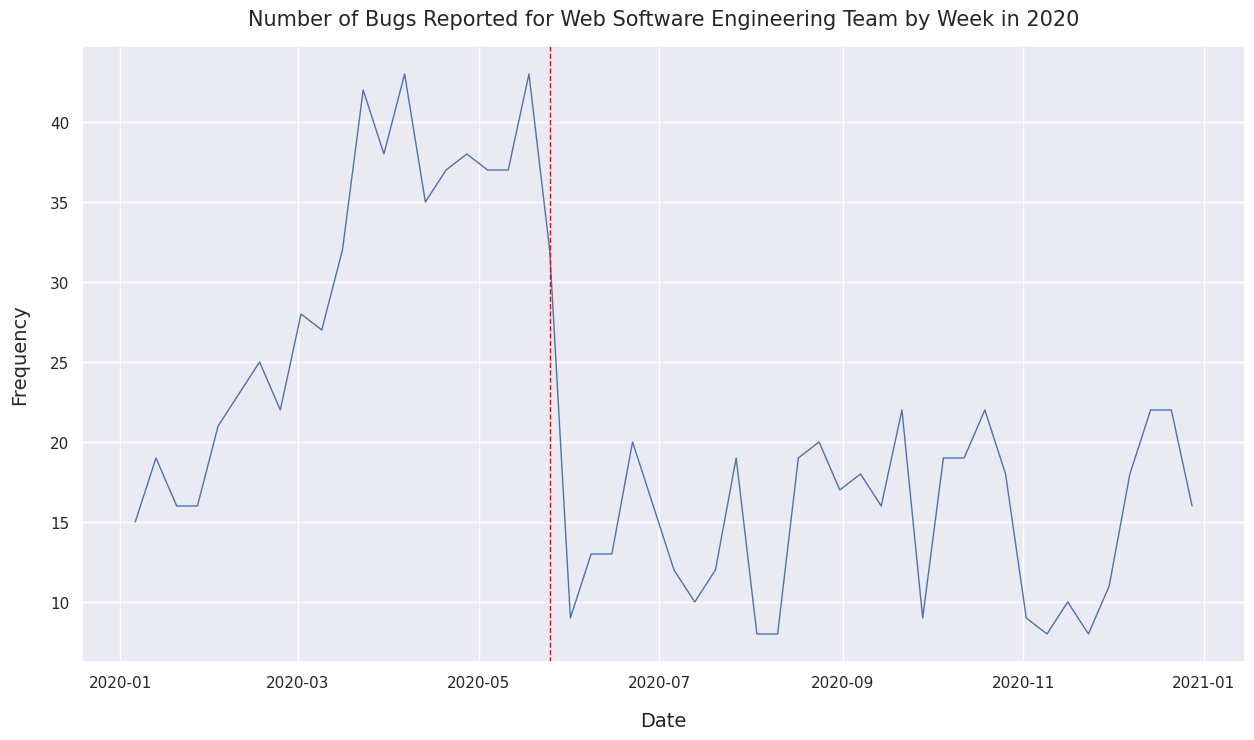

In [11]:
from matplotlib import lines
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_web, x='date', y='bugs', linewidth=1)
s.set_title('Number of Bugs Reported for Web Software Engineering Team by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(pd.to_datetime('2020-05-25'), color='red', linewidth=1, linestyle='--')

An interesting observation being made here is that, we are seeing a sharp rise in bugs report bugs prior to May 2025, the trend was increasing and then after May 2025, we see a steep drop and a relative lower reported bugs with relative stability but for now we can not definitively attribute it software engineering training yet, however, we can speculate.

In [12]:
# Subsetting then visualizing trend for bugs for IOS engineering team.
df_ios = df[df['channel'] == 'iOS']
df_ios.head()

,channel,date,bugs
0,iOS,2020-01-06,15
1,iOS,2020-01-13,13
2,iOS,2020-01-20,17
3,iOS,2020-01-27,21
4,iOS,2020-02-03,12


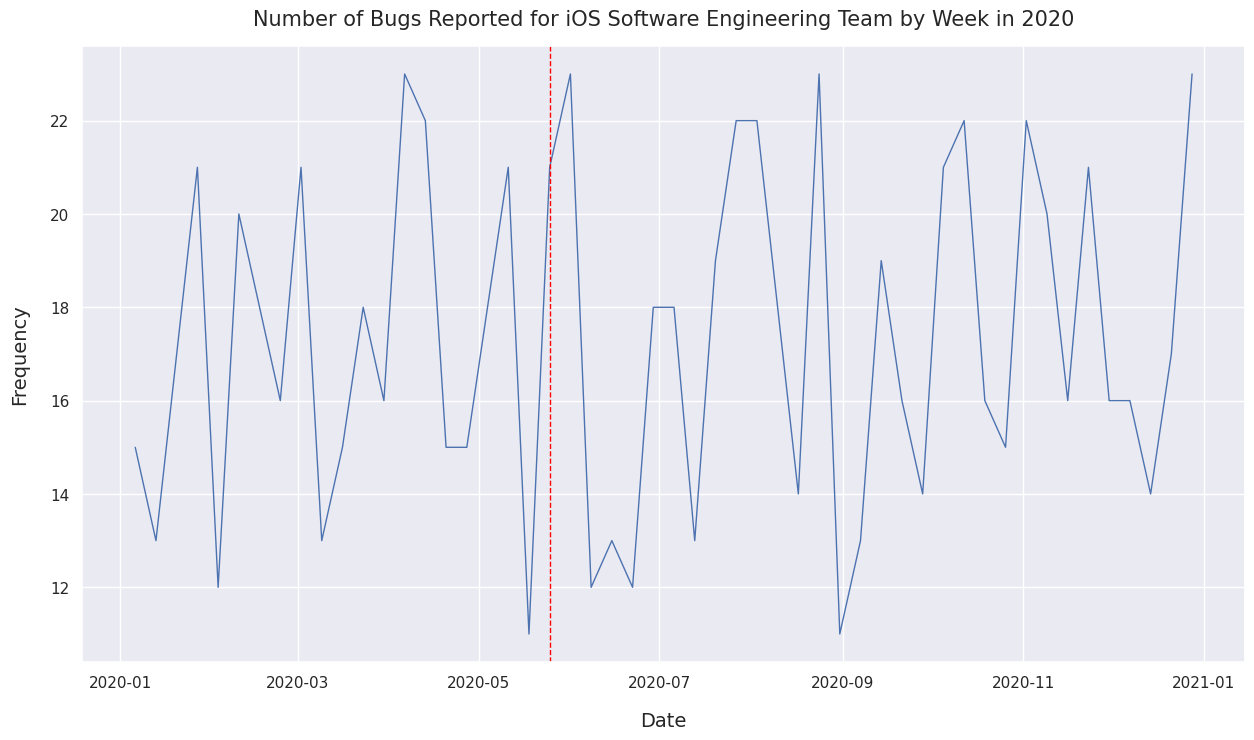

In [13]:
from matplotlib import lines
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_ios, x='date', y='bugs', linewidth=1)
s.set_title('Number of Bugs Reported for iOS Software Engineering Team by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(pd.to_datetime('2020-05-25'), color='red', linewidth=1, linestyle='--')

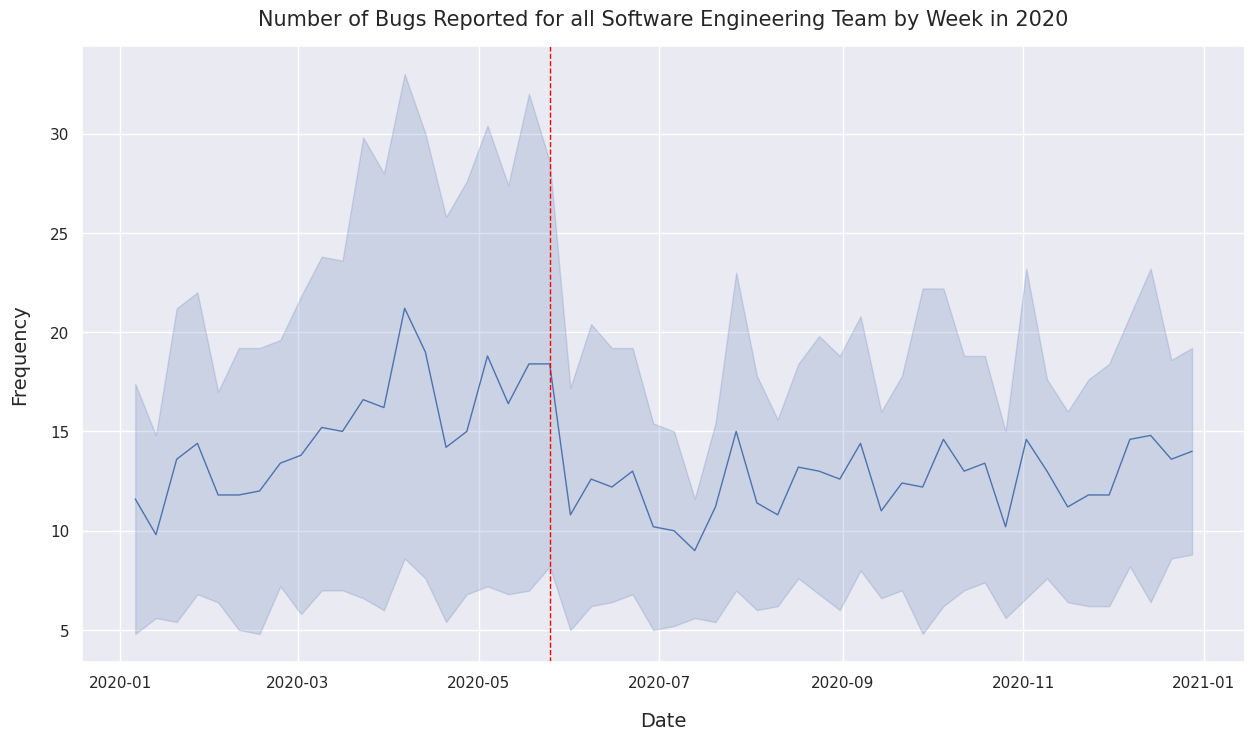

In [14]:
#Ploting and visualizing for all class categories
from matplotlib import lines
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df, x='date', y='bugs', linewidth=1)
s.set_title('Number of Bugs Reported for all Software Engineering Team by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(pd.to_datetime('2020-05-25'), color='red', linewidth=1, linestyle='--')

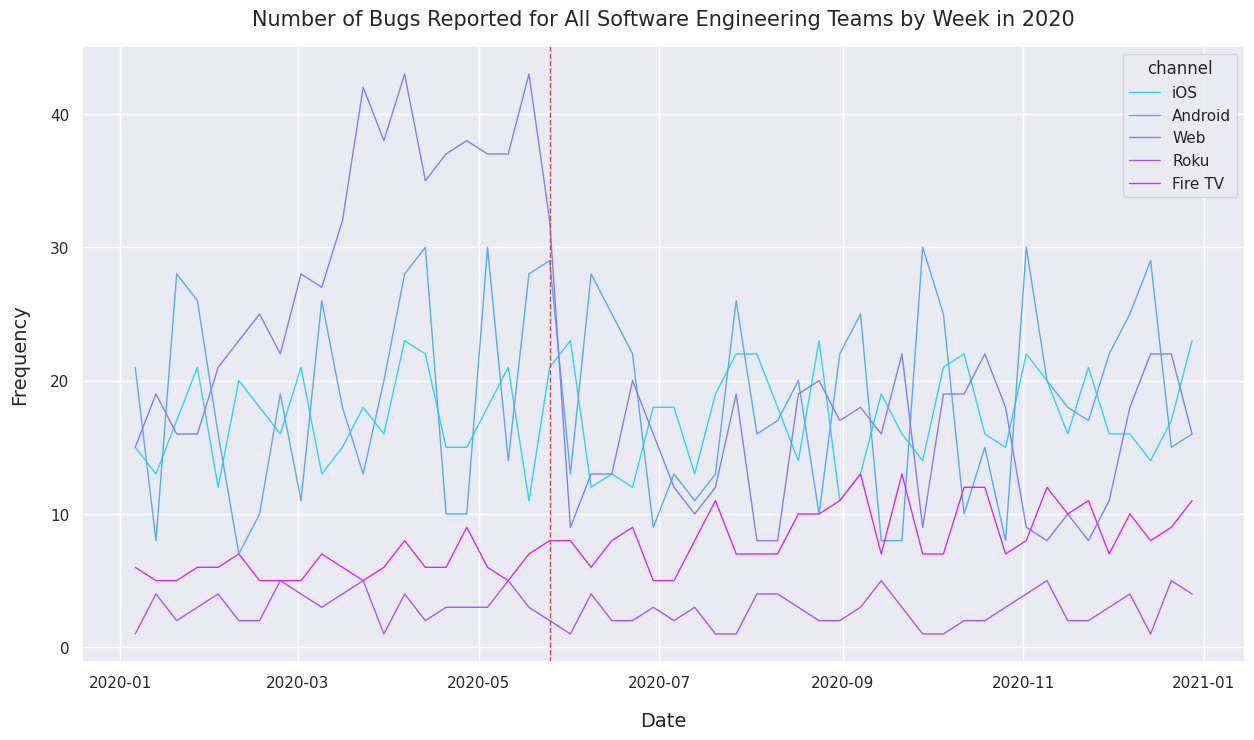

In [15]:
# Plot the bugs reported for all software engineering teams during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df, x="date", y='bugs', hue='channel', linewidth=1, palette='cool')
s.set_title('Number of Bugs Reported for All Software Engineering Teams by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(dt.datetime(2020,5,25), color='r', linewidth=1, linestyle='--')
plt.show()

So here we see a trend were aside the web software engineering team all other teams seams to have relative stability in terms of bug reported. I have an assumption that this might be so because we are seeing a we do not have enough historical data and only the obvious changes will be noticed by visualization.

# Measuring Causal Impact using Bayesian Structural Time series(BSTS).
his is one of the most potent methodologies for measuring causal impact without a control group. It employs Bayesian priors for estimating trend, seasonality, and regression components. The forecast from this model serves as a counterfactual, which is then used for comparison against actual data points, and the delta between the two represents the causal effect.

The idea is train our model on historical data prior to intervention period, generate a forecast during the intervention period and then compare it to treated values at the same time, the results becomes the causal effect we are looking for.

In [23]:
#Transform your Data first into a pivot table.
df_tr = pd.pivot_table(df, values='bugs', index='date', columns='channel', aggfunc=np.sum)
# Position the Web column as the first column. since it is our Y.  All other columns are our X.
df_tr = df_tr[['Web', 'Android', 'iOS', 'Roku', 'Fire TV']]
df_tr.head()

channel,Web,Android,iOS,Roku,Fire TV
date,,,,,
2020-01-06,15,21,15,1,6
2020-01-13,19,8,13,4,5
2020-01-20,16,28,17,2,5
2020-01-27,16,26,21,3,6
2020-02-03,21,16,12,4,6


In [24]:
df_tr.head()

channel,Web,Android,iOS,Roku,Fire TV
date,,,,,
2020-01-06,15,21,15,1,6
2020-01-13,19,8,13,4,5
2020-01-20,16,28,17,2,5
2020-01-27,16,26,21,3,6
2020-02-03,21,16,12,4,6


In [25]:
# Flatten the pivot table and set the index of the dataframe to the date column.
# df_flattened = pd.DataFrame(df_piv.to_records()).reset_index(drop=True)
# df_flattened = df_flattened.set_index('date')
# df_flattened.head()

In [26]:
#The next thing is to flatten the pivot table and to set the index of the pivot table to date
df_flat = pd.DataFrame(df_tr.to_records()).reset_index(drop=True)
df_flat = df_flat.set_index('date')
df_flat.head()

,Web,Android,iOS,Roku,Fire TV
date,,,,,
2020-01-06,15,21,15,1,6
2020-01-13,19,8,13,4,5
2020-01-20,16,28,17,2,5
2020-01-27,16,26,21,3,6
2020-02-03,21,16,12,4,6


# Running the cuasal inference model.

If the data isn't divided already as we would see in this model, we will have to perform the division ourselve. If the data is divided then we can just clean respectively and work with it.

In [27]:
# Setting the pre and post traing periods for the software engineering teams to able to measure the causal impact.
pre_period = ['20200106', '20200525']
post_period = ['20200601', '20201228']

In [28]:
#Running the model
ci = CausalImpact(df_flat, pre_period, post_period, prior_level_sd=None)

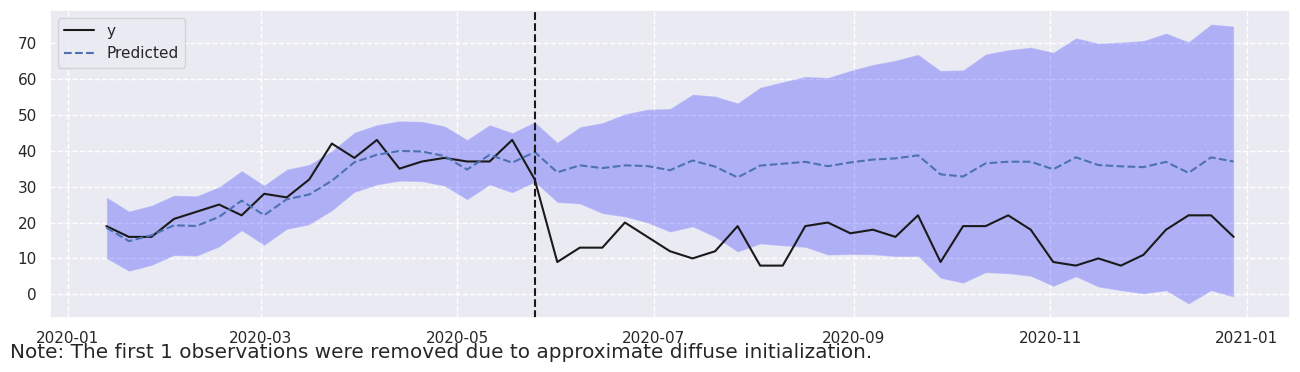

In [29]:
ci.plot(panels=['original'], figsize=(16,4))

**Takeaway**: We are comparing the trend in actual bugs reported by the Web software engineering team with the forecasted values over the same period. We observe a consistent pattern in which the forecast remains above the actual reported data, beginning from the point at which the training intervention was applied. This divergence suggests that the treatment (training) had a measurable effect on the team’s performance, resulting in fewer reported bugs than would have been expected without the intervention.

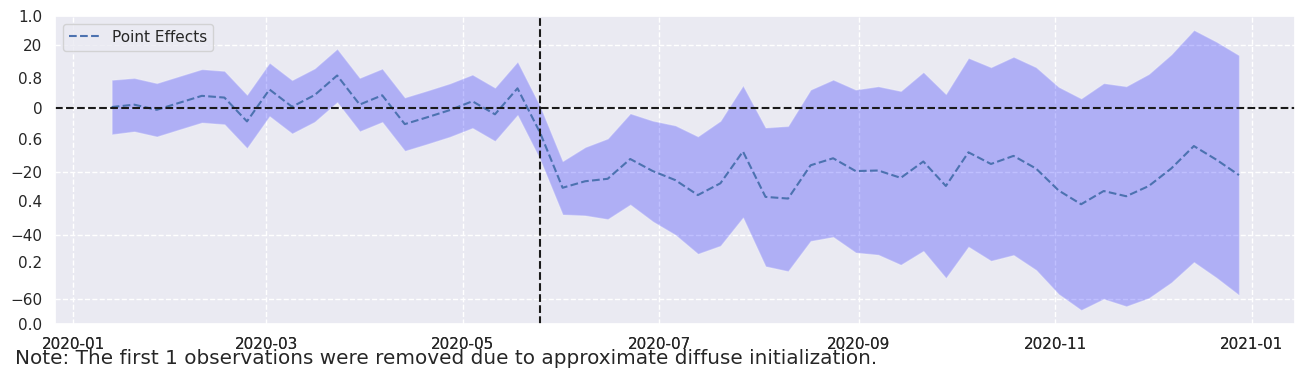

In [30]:
ci.plot(panels=['pointwise'], figsize=(16,4))

This plot shows the difference between actual series and and predicted series overtime which is referred to as point effect.

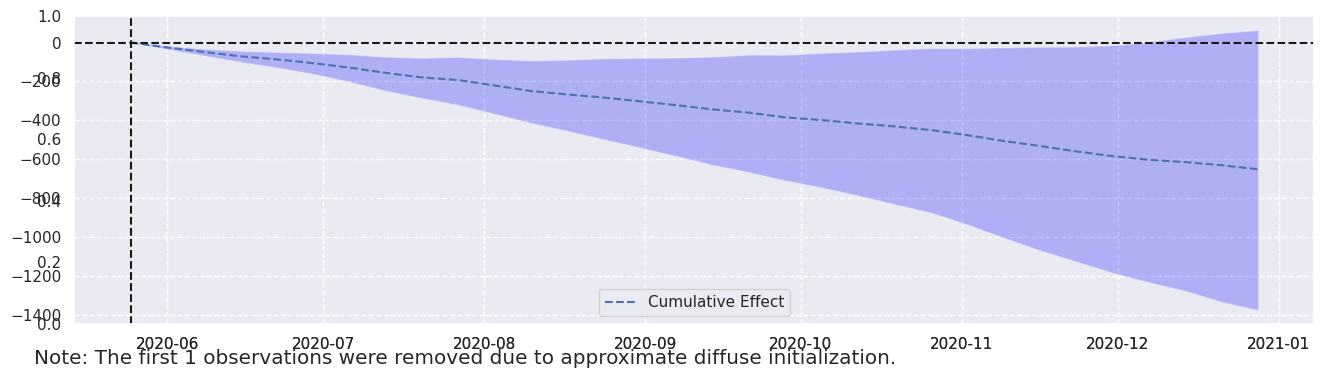

In [32]:
ci.plot(panels=['cumulative'], figsize=(16,4))

This plot shows the cumulative effect.That is the summation of data point.

In [37]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14.94              463.0
Prediction (s.d.)         35.96 (11.85)      1114.91 (367.41)
95% CI                    [12.85, 59.31]     [398.25, 1838.48]

Absolute effect (s.d.)    -21.03 (11.85)     -651.91 (367.41)
95% CI                    [-44.37, 2.09]     [-1375.48, 64.75]

Relative effect (s.d.)    -58.47% (32.95%)   -58.47% (32.95%)
95% CI                    [-123.37%, 5.81%]  [-123.37%, 5.81%]

Posterior tail-area probability p: 0.04
Posterior prob. of a causal effect: 96.0%

For more details run the command: print(impact.summary('report'))


In [36]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 14.94. In the absence of an
intervention, we would have expected an average response of 35.96.
The 95% interval of this counterfactual prediction is [12.85, 59.31].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -21.03 with a 95% interval of
[-44.37, 2.09]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 463.0.
Had the intervention not taken place, we would have expected
a sum of 1114.91. The 95% interval of this prediction is [398.25, 1838.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of 